In [ ]:
import cv2
import os
import pandas as pd
import numpy as np
import h5py
import pickle
import random
import tensorflow as tf
from tensorflow.keras import layers,regularizers
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.layers import Conv2D, Activation,AveragePooling2D,BatchNormalization
from keras import backend as K
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
filename = "/content/gdrive/My Drive/Colab Notebooks/THESIS/CSV/data_labels.h5"
with h5py.File(filename, 'r') as f:
    all_uav_xyzHTR = np.asarray(list(f['all_uav_xyzHTR']))
    match_array = np.asarray(list(f['match_array_40']))

In [ ]:
match_array1=match_array[:,800:2078]
match_array2=match_array[:,2078:3075]
match_array3=match_array[:,3075:4272]
match_array5=match_array[:,11466:14581]
match_array6=match_array[:,14581:16167]
match_array7=match_array[:,16167:17059]
match_array12=np.concatenate((match_array1,match_array2,match_array3,match_array5,match_array6,match_array7)
                                               ,axis=1)
match_array1 = match_array12[800:2078,:]
match_array2=match_array12[2078:3075,:]
match_array3=match_array12[3075:4272,:]
match_array5=match_array12[11466:14581,:]
match_array6=match_array12[14581:16167,:]
match_array7=match_array12[16167:17059,:]
match_array12=np.concatenate((match_array1,match_array2,match_array3,match_array5,match_array6,match_array7)
                            ,axis=0)
print(match_array12.shape)
matching_pairs = np.transpose(np.nonzero(match_array12))
print(matching_pairs)

(9065, 9065)
[[   0    0]
 [   0    4]
 [   0   22]
 ...
 [9062 9062]
 [9063 9063]
 [9064 9064]]


In [ ]:
f=open('/content/gdrive/MyDrive/Colab Notebooks/THESIS/pickle_alexnet/uav/atlanta_uav','rb')
training_data1=pickle.load(f)
f.close()
f=open('/content/gdrive/MyDrive/Colab Notebooks/THESIS/pickle_alexnet/uav/austin_uav','rb')
training_data2=pickle.load(f)
f.close()
f=open('/content/gdrive/MyDrive/Colab Notebooks/THESIS/pickle_alexnet/uav/boston_uav','rb')
training_data3=pickle.load(f)
f.close()
f=open('/content/gdrive/MyDrive/Colab Notebooks/THESIS/pickle_alexnet/uav/chicago_uav','rb')
training_data5=pickle.load(f)
f.close()
f=open('/content/gdrive/MyDrive/Colab Notebooks/THESIS/pickle_alexnet/uav/miami_uav','rb')
training_data6=pickle.load(f)
f.close()
f=open('/content/gdrive/MyDrive/Colab Notebooks/THESIS/pickle_alexnet/uav/sanfrancisco_uav','rb')
training_data7=pickle.load(f)
f.close()

In [ ]:
uav=np.array(training_data1[800:2078]+training_data2+training_data3+training_data5+training_data6+training_data7,dtype='float16')

In [ ]:

f=open('/content/gdrive/MyDrive/Colab Notebooks/THESIS/pickle_alexnet/sat/atlanta_sat','rb')
training_dat1=pickle.load(f)
f.close()
f=open('/content/gdrive/MyDrive/Colab Notebooks/THESIS/pickle_alexnet/sat/austin_sat','rb')
training_dat2=pickle.load(f)
f.close()
f=open('/content/gdrive/MyDrive/Colab Notebooks/THESIS/pickle_alexnet/sat/boston_sat','rb')
training_dat3=pickle.load(f)
f.close()
f=open('/content/gdrive/MyDrive/Colab Notebooks/THESIS/pickle_alexnet/sat/chicago_sat','rb')
training_dat5=pickle.load(f)
f.close()
f=open('/content/gdrive/MyDrive/Colab Notebooks/THESIS/pickle_alexnet/sat/miami_sat','rb')
training_dat6=pickle.load(f)
f.close()
f=open('/content/gdrive/MyDrive/Colab Notebooks/THESIS/pickle_alexnet/sat/sanfrancisco_sat','rb')
training_dat7=pickle.load(f)
f.close()

In [ ]:
sat=np.array(training_dat1[800:2078]+training_dat2+training_dat3+training_dat5+training_dat6+training_dat7
              ,dtype='float16')

In [ ]:
print(uav.shape)
print(sat.shape)
print(matching_pairs.shape)

(9065, 227, 227, 3)
(9065, 227, 227, 3)
(17271, 2)


In [ ]:
del training_data7,training_data6,training_data3,training_data2
del training_dat2,training_dat5,training_data5
del training_dat3,training_dat1,training_data1
del training_dat6,training_dat7

In [ ]:

# Generate same number of non-matching pairs
non_match_pairs = []
for i in range(len(match_array12)):
    match_idx = np.nonzero(match_array12[i,:])
    match_idx = np.asarray(match_idx)
    for j in range(match_idx.size):
        rand_idx = np.random.randint(len(match_array12))
        while(rand_idx in match_idx):
            rand_idx = np.random.randint(len(match_array12))
        non_match_pairs.append(np.array([i, rand_idx]))
non_match_pairs = np.asarray(non_match_pairs)
print(non_match_pairs.shape)

(17271, 2)


In [ ]:
choose_idx_match = []
choose_idx_nonmt = []
n_validby2 = 1727
while(len(choose_idx_match) < n_validby2):
    to_append = np.random.randint(len(matching_pairs))
    if to_append not in choose_idx_match:
        choose_idx_match.append(to_append)
while(len(choose_idx_nonmt) < n_validby2):
    to_append = np.random.randint(len(non_match_pairs))
    if to_append not in choose_idx_nonmt:
        choose_idx_nonmt.append(to_append)
valmatchpairs,valnonmatpairs=matching_pairs[choose_idx_match], non_match_pairs[choose_idx_nonmt]

In [ ]:
pairs=[]
labels=[]
for i in range(len(valmatchpairs)):
            z1, z2 = valmatchpairs[i]
            pairs += [[uav[z1], sat[z2]]]
            z1, z2 = valnonmatpairs[i]
            pairs += [[uav[z1], sat[z2]]]
            labels += [1,0]
validpairs=np.array(pairs,dtype='float16')
validlabels=np.array(labels)

In [ ]:
mask_match = np.ones(len(matching_pairs), dtype = bool)
mask_match[choose_idx_match] = False
mask_nonmt = np.ones(len(non_match_pairs), dtype = bool)
mask_nonmt[choose_idx_nonmt] = False
train_match_pairs = matching_pairs[mask_match]
train_nonmt_pairs = non_match_pairs[mask_nonmt]
train_pairs = np.concatenate((train_match_pairs, train_nonmt_pairs), axis = 0)

In [ ]:
pairs=[]
labels=[]
for i in range(len(train_match_pairs)):
            z1, z2 = train_match_pairs[i]
            pairs += [[uav[z1], sat[z2]]]
            z1, z2 = train_nonmt_pairs[i]
            pairs += [[uav[z1], sat[z2]]]
            labels += [1,0]
trpairs=np.array(pairs,dtype='float16')
trlabels=np.array(labels)

In [ ]:
del uav,sat,pairs

In [ ]:
import pickle
rand_idx = '/content/gdrive/MyDrive/Colab Notebooks/MODELS/rand_idx'
validp = '/content/gdrive/MyDrive/Colab Notebooks/MODELS/mat94659'
validlab = '/content/gdrive/MyDrive/Colab Notebooks/MODELS/nonmat94659'

with open(validp, 'wb') as f:
    pickle.dump(choose_idx_match, f)
with open(validlab, 'wb') as f:
    pickle.dump(choose_idx_nonmt, f)
with open(rand_idx, 'wb') as f:
    pickle.dump(rand_idx, f)

In [ ]:

def Alexnet(input,num_classes=1000, drop_rate=0.5, regularizer_rate=0.0002):
    """
         The AlexNet pre-training model structure implemented in PyTorch has a depth of (64, 192, 384, 256, 256).
         Returns the inputs and outputs of AlexNet
    """
    #inputs = layers.Input(shape=img_shape)

    conv1 = layers.Conv2D(64, (11, 11), strides=(4, 4), padding='valid', activation='relu')(input)

    pool1 = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv1)

    conv2 = layers.Conv2D(192, (5, 5), strides=(1, 1), padding='same', activation='relu')(pool1)

    pool2 = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv2)

    conv3 = layers.Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu')(pool2)

    conv4 = layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu')(conv3)

    conv5 = layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu')(conv4)

    pool3 = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv5)

    flat = layers.Flatten()(pool3)

    dense1 = layers.Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(regularizer_rate))(flat)
    dense1 = layers.Dropout(drop_rate)(dense1)
    dense2 = layers.Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(regularizer_rate))(dense1)
    dense2 = layers.Dropout(drop_rate)(dense2)
    outputs = layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(regularizer_rate))(dense2)
    model = tf.keras.Model(input, outputs)
    model.load_weights('/content/gdrive/MyDrive/Colab Notebooks/THESIS_COMPLETE/keras_alexnet.h5')
    model2 = Model(model.input, model.layers[-5].output)
    return model2

In [ ]:
  def Model1(shape):
    input = Input(shape = shape)
    resnet1=Alexnet(input)
    model = Model(input, resnet1.output)
    #model.summary()
    return model
  def Model2(shape):
    input = Input(shape=shape)
    resnet2=Alexnet(input)
    model = Model(input, resnet2.output)
    return model

In [ ]:
def contrastive_loss(y_true, y_pred):
    margin = 100
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    y_true = tf.cast(y_true, dtype='float64')
    square_pred = tf.cast(square_pred, dtype='float64')
    margin_square = tf.cast(margin_square, dtype='float64')
    path=K.mean((y_true)*(square_pred) + (1 - y_true)*(margin_square))
    return path

def euclid_dis(vects):
    x,y = vects
    sum_square = K.sum(K.square(x-y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 50
    return np.mean(pred == y_true)

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 50, y_true.dtype)))

In [ ]:
from keras.layers import Input, Flatten, Dense, Dropout, Lambda,concatenate
base_network =Model1((227,227, 3))
base_network =Model2((227,227, 3))
input_shape=(227,227,3)
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)
distance = Lambda(euclid_dis,
                output_shape=eucl_dist_output_shape)([processed_a, processed_b])
model = Model([input_a, input_b],distance)

In [ ]:
class DataGenerator(keras.utils.Sequence):
    #'Generates data for Keras'
    def __init__(self, UAV,SAT,TRLABELS1,
                 batch_size=128, image_dimensions = (227 ,227 ,3)):

        self.UAV = UAV
        self.SAT = SAT
        self.TRLABELS1= TRLABELS1
        self.batch_size = batch_size
        self.on_epoch_end()
    def __len__(self):
        #'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.UAV) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.UAV))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]


        # select data and load images
        mask1 = tf.convert_to_tensor([ self.TRLABELS1[k] for k in indexes])
        image1 = tf.convert_to_tensor([ self.UAV[k] for k in indexes])
        image2 = tf.convert_to_tensor([ self.SAT[k] for k in indexes])
        return [image1, image2], [mask1]

In [ ]:
train_generator = DataGenerator(trpairs[:, 0],trpairs[:,1],trlabels)
val_generator = DataGenerator(validpairs[:,0],validpairs[:,1],validlabels)

In [ ]:
from keras.callbacks import LearningRateScheduler
import numpy as np
checkpoint_filepath = '/content/gdrive/MyDrive/Colab Notebooks/THESIS_COMPLETE/MODELS/checkpoint120421_0106'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=False)
csv_logger =tf.keras.callbacks.CSVLogger('/content/gdrive/MyDrive/Colab Notebooks/training120421_0106.log')
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=1, min_lr=5e-05,verbose=1)
callback=keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=0, mode='min')
lr_shed=keras.callbacks.LearningRateScheduler(lambda epoch:5e-6 * 10** (epoch/2),verbose=1)
model.compile(loss=contrastive_loss, optimizer=keras.optimizers.Adam(), metrics=[accuracy])
history = model.fit(train_generator,
    steps_per_epoch=np.floor(len(trlabels)/128), 
    epochs=7,
    verbose=1,
    validation_data = val_generator,
    validation_steps=np.floor(len(validlabels)/128),callbacks=[csv_logger,lr_shed,model_checkpoint_callback])

Epoch 1/7

Epoch 00001: LearningRateScheduler reducing learning rate to 5e-06.
242/242 [==============================] - 5847s 24s/step - loss: 2459.5152 - accuracy: 0.6088 - val_loss: 1912.6268 - val_accuracy: 0.7422
Epoch 2/7

Epoch 00002: LearningRateScheduler reducing learning rate to 1.5811388300841898e-05.
242/242 [==============================] - 5672s 23s/step - loss: 1801.4708 - accuracy: 0.7576 - val_loss: 1489.1384 - val_accuracy: 0.8089
Epoch 3/7

Epoch 00003: LearningRateScheduler reducing learning rate to 5e-05.
242/242 [==============================] - 5660s 23s/step - loss: 1452.5263 - accuracy: 0.8183 - val_loss: 1199.0675 - val_accuracy: 0.8573
Epoch 4/7

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00015811388300841897.
242/242 [==============================] - 5690s 23s/step - loss: 1249.4523 - accuracy: 0.8500 - val_loss: 1063.8833 - val_accuracy: 0.8786
Epoch 5/7

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0005.
242/242 [=

Text(0.5, 1.0, 'Loss vs Learning Rate')

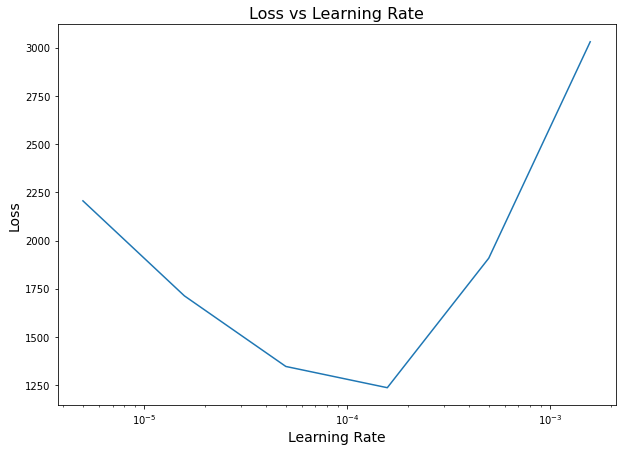

In [ ]:
import matplotlib.pyplot as plt
lrs=5e-6 * (10**(tf.range(6)/2))
plt.figure(figsize=(10,7))
x=history.history["loss"]
plt.semilogx(lrs,x[:6])
plt.xlabel("Learning Rate",fontsize=14)
plt.ylabel("Loss",fontsize=14)
plt.title("Loss vs Learning Rate",fontsize=16)

In [ ]:
from keras.callbacks import LearningRateScheduler
import numpy as np
checkpoint_filepath = '/content/gdrive/MyDrive/Colab Notebooks/THESIS_COMPLETE/MODELS/checkpoint1104210155'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
csv_logger =tf.keras.callbacks.CSVLogger('/content/gdrive/MyDrive/Colab Notebooks/training1104210155.log')
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=1, min_lr=5e-5,verbose=1)
callback=keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=0, mode='min')
model.compile(loss=contrastive_loss, optimizer=keras.optimizers.Adam(5e-5), metrics=[accuracy])
history = model.fit(train_generator,
    steps_per_epoch=np.floor(len(trlabels)/128), 
    epochs=7,
    verbose=1,
    validation_data = val_generator,
    validation_steps=np.floor(len(validlabels)/128),callbacks=[csv_logger,model_checkpoint_callback,callback])

Epoch 1/7
242/242 [==============================] - 5382s 22s/step - loss: 1993.8243 - accuracy: 0.7075 - val_loss: 1335.7323 - val_accuracy: 0.8407
Epoch 2/7
242/242 [==============================] - 5394s 22s/step - loss: 1260.6057 - accuracy: 0.8528 - val_loss: 1103.3237 - val_accuracy: 0.8834
Epoch 3/7
242/242 [==============================] - 5424s 22s/step - loss: 1071.6401 - accuracy: 0.8877 - val_loss: 1062.9937 - val_accuracy: 0.8891
Epoch 4/7
242/242 [==============================] - 5422s 22s/step - loss: 946.9146 - accuracy: 0.9080 - val_loss: 935.0248 - val_accuracy: 0.9078
Epoch 5/7
242/242 [==============================] - 5610s 23s/step - loss: 838.8986 - accuracy: 0.9241 - val_loss: 847.8334 - val_accuracy: 0.9207
Epoch 6/7
242/242 [==============================] - 5430s 22s/step - loss: 769.3638 - accuracy: 0.9370 - val_loss: 800.0505 - val_accuracy: 0.9294
Epoch 7/7
242/242 [==============================] - 5432s 22s/step - loss: 687.3667 - accuracy: 0.9457 - 

In [ ]:
new_model=keras.models.load_model("/content/gdrive/MyDrive/Colab Notebooks/MODELS/model110421_9305",compile=False)

In [ ]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,1699.318848,0.765247,1335.732300,0.840745
1,1219.043213,0.863397,1103.323730,0.883413
2,1034.952026,0.894647,1062.993652,0.889123
3,923.115906,0.911185,935.024841,0.907752
4,839.064514,0.924282,847.833435,0.920673
5,758.493652,0.937625,800.050476,0.929387
6,711.449951,0.943666,771.077087,0.931190


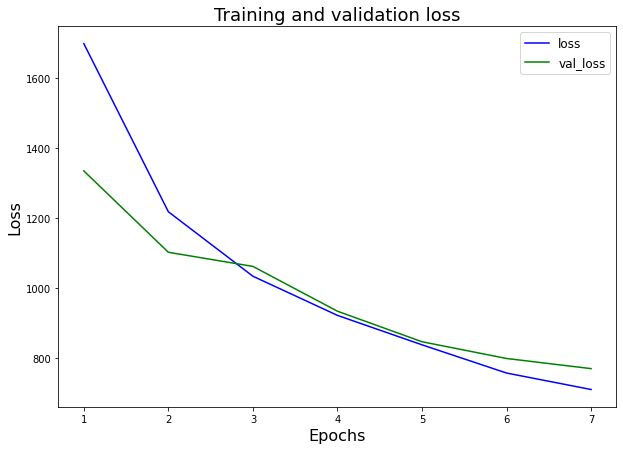

In [ ]:
# LOSS Learning curves
history_dict = history.history
loss_values = df['loss']
val_loss_values = df['val_loss']
epochs = range(1, (len(history.history['loss']) + 1))
plt.figure(figsize=(10,7))
plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values,color='g', label='Validation loss')
plt.title('Training and validation loss',fontsize=18)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend(['loss','val_loss'],fontsize=12)
plt.show()

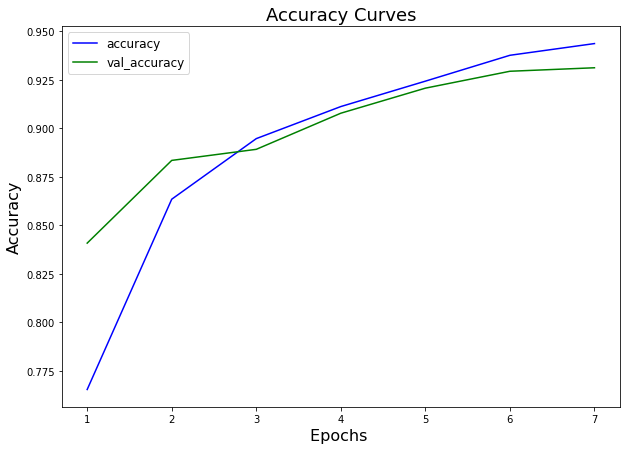

In [ ]:
file_name = "/content/gdrive/MyDrive/Colab Notebooks/training1104210155.log"
df = pd.read_csv(file_name)
accuracy = df['accuracy']
val_accuracy = df['val_accuracy']
epochs = range(1, (len(history.history['loss']) + 1))
plt.figure(figsize=(10,7))
plt.plot(epochs,accuracy,color='b',label='accuracy')
plt.plot(epochs, val_accuracy,color='g', label='Val_accuracy')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=18)
plt.legend(['accuracy','val_accuracy'],fontsize=12)
plt.show()

In [ ]:
pairs=[]
labels=[]
match_array13 = match_array[:,0:800]
match_array13 = match_array13[0:800,:]
print(match_array12.shape)
matching_pairs1 = np.transpose(np.nonzero(match_array13))
print(matching_pairs1)
uav1=np.array(training_data1[0:800],dtype='float16')
sat1=np.array(training_dat1[0:800],dtype='float16')
non_match_pairs = []
for i in range(len(match_array13)):
    match_idx = np.nonzero(match_array13[i,:])
    match_idx = np.asarray(match_idx)
    for j in range(match_idx.size):
        rand_idx = np.random.randint(len(match_array13))
        while(rand_idx in match_idx):
            rand_idx = np.random.randint(len(match_array13))
        non_match_pairs.append(np.array([i, rand_idx]))
non_match_pairs = np.asarray(non_match_pairs)
print(non_match_pairs.shape)
choose_idx_match1 = []
choose_idx_nonmt1 = []
n_validby2 = 0
while(len(choose_idx_match1) < n_validby2):
    to_append = np.random.randint(len(matching_pairs1))
    if to_append not in choose_idx_match1:
        choose_idx_match1.append(to_append)   
while(len(choose_idx_nonmt1) < n_validby2):
    to_append = np.random.randint(len(non_match_pairs))
    if to_append not in choose_idx_nonmt:
        choose_idx_nonmt1.append(to_append)
mask_match = np.ones(len(matching_pairs1), dtype = bool)
mask_match[choose_idx_match1] = False
mask_nonmt = np.ones(len(non_match_pairs), dtype = bool)
mask_nonmt[choose_idx_nonmt1] = False
match_pairs = matching_pairs1[mask_match]
nonmt_pairs = non_match_pairs[mask_nonmt]
for i in range(len(match_pairs)):
            z1, z2 = match_pairs[i]
            pairs += [[uav1[z1], sat1[z2]]]
            z1, z2 = nonmt_pairs[i]
            pairs += [[uav1[z1], sat1[z2]]]
            labels += [1,0]
testpairs=np.array(pairs,dtype='float16')
testlabels=np.array(labels)

In [ ]:
# make a histogram of the distances from results of inference
import matplotlib.pyplot as plt
def histo(preds, y_pred,stri):
    matdist, nmatdist = [], []
    for i in range(len(preds)):
        if preds[i] == 0: nmatdist.append(y_pred[i])
        if preds[i] == 1: matdist.append(y_pred[i])
    #print(nmatdist)
    nmatdist=np.array(nmatdist)
    #print(nmatdist)
    matdist=np.array(matdist)
    mathist  = plt.hist( matdist, range(int(np.ceil(max( matdist)))), label = 'matching pairs', alpha = 0.5)
    nmathist = plt.hist(nmatdist, range(int(np.ceil(max(nmatdist)))), label = 'non-matching pairs', alpha = 0.5)
    plt.legend(loc='best')
    plt.title(stri + ' data')
    plt.xlabel('Distance between image pairs')
    plt.show()       

In [ ]:
y_pred1 = new_model.predict([trpairs[:, 0], trpairs[:, 1]])
tr_acc = compute_accuracy(trlabels, y_pred1)
print('Accuracy on train set:      %0.2f%%' % (100 * tr_acc))
y_pred2 = new_model.predict([validpairs[:, 0], validpairs[:, 1]])
tp_acc = compute_accuracy(validlabels, y_pred2)
print('Accuracy on validation set: %0.2f%%' % (100 * tp_acc))
y_pred3 = new_model.predict([atlantapairs[:, 0], atlantapairs[:, 1]])
test_acc = compute_accuracy(atlantalabels, y_pred3)
print('Accuracy on test set:       %0.2f%%' % (100 * test_acc))

Accuracy on train set:      92.64%
Accuracy on validation set: 91.60%
Accuracy on test set:       87.12%


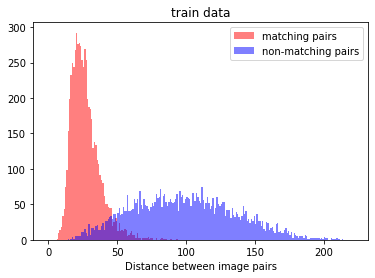

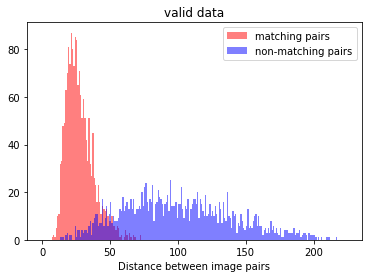

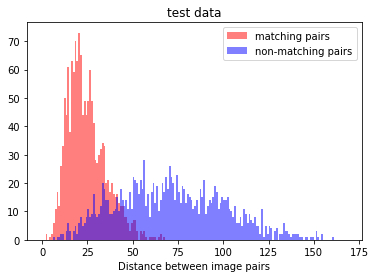

In [ ]:
histo(trlabels,y_pred1,'train')
histo(validlabels,y_pred2,'valid')
histo(atlantalabels,y_pred3,'test')